In [1]:
import scanpy as sc
import cell2location
from cell2location.models import RegressionModel
from sklearn.model_selection import train_test_split

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-31 13:25:10.829389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 13:25:10.837557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 13:25:10.840145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 13:25:11.263859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [2]:
# load reference scRNA-seq data

sc_ref = sc.read_h5ad('../data/adata_annotated.h5ad')
sc_ref

AnnData object with n_obs × n_vars = 3261 × 17282
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'tumor_cell', 'cnv_leiden', 'cnv_score', 'cell_type'
    var: 'chromosome', 'start', 'end', 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'tumor_cell_colors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [3]:
sc_ref.var['SYMBOL'] = sc_ref.var_names   # save var_names to 'SYMBOL'
sc_ref.var.set_index('gene_ids', drop = True, inplace = True)    # set ENSEMBL ID as index

# delete unnecessary raw slot
del sc_ref.raw

In [4]:
sc_ref.var

,chromosome,start,end,feature_types,genome,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std,SYMBOL
gene_ids,,,,,,,,,,,,,,,
ENSG00000177757,chr1,817371,819837,Gene Expression,GRCh38,10,False,0.003980,0.150140,-0.001102,1,False,0.002824,0.058902,FAM87B
ENSG00000225880,chr1,824228,827539,Gene Expression,GRCh38,110,False,0.043453,0.712847,-0.744003,0,False,0.029729,0.174624,LINC00115
ENSG00000230368,chr1,868071,876903,Gene Expression,GRCh38,77,False,0.038254,0.841007,-0.458932,0,False,0.019073,0.142729,FAM41C
ENSG00000187634,chr1,923923,944575,Gene Expression,GRCh38,10,False,0.018607,1.035632,0.198773,2,False,0.003069,0.079662,SAMD11
ENSG00000188976,chr1,944203,959309,Gene Expression,GRCh38,421,False,0.207137,1.296971,0.280509,1,False,0.122288,0.355127,NOC2L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000212907,chrM,10470,10766,Gene Expression,GRCh38,2173,False,1.583785,1.981731,-0.721426,0,False,1.126615,0.969058,MT-ND4L
ENSG00000198886,chrM,10760,12137,Gene Expression,GRCh38,2924,False,3.554795,3.208965,-0.683389,0,False,3.131164,1.298940,MT-ND4
ENSG00000198786,chrM,12337,14148,Gene Expression,GRCh38,2646,False,2.528544,2.564114,-0.942584,0,False,2.072005,1.215068,MT-ND5


/home/jsw/jswenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


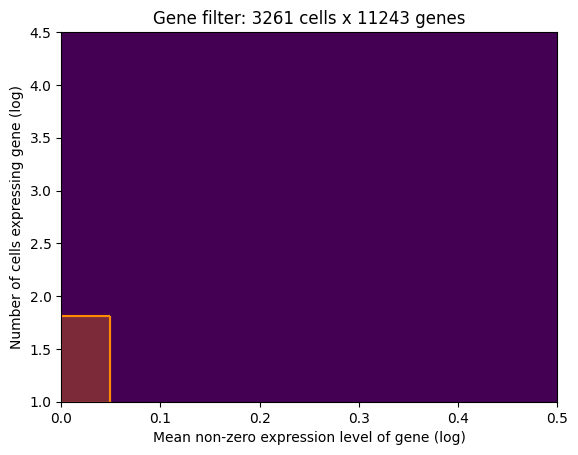

In [5]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(sc_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.02, nonz_mean_cutoff=1.12)

In [6]:
# filter the object
sc_ref = sc_ref[:, selected].copy()

In [7]:
sc_ref

AnnData object with n_obs × n_vars = 3261 × 11243
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'tumor_cell', 'cnv_leiden', 'cnv_score', 'cell_type'
    var: 'chromosome', 'start', 'end', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'SYMBOL', 'nonz_mean'
    uns: 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'tumor_cell_colors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [8]:
train_adata, val_adata = sc_ref[sc_ref.obs_names[:int(0.8 * len(sc_ref))]], sc_ref[sc_ref.obs_names[int(0.8 * len(sc_ref)):]]

In [9]:
# Prepare anndata for the regression mocel (Negative binomial regression)
cell2location.models.RegressionModel.setup_anndata(
    adata = sc_ref,
    labels_key = 'cell_type',
    layer = 'counts'
)

In [10]:
# Create the regression model
mod = RegressionModel(sc_ref)

# View andata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3261  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  11   │
│          n_vars          │ 11243 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │    Malignant     │          0          │
│                        │      Mo/Mp       │          1          │
│                        │    Microglia     │          2          │
│                        │       CD4        │          3          │
│                        │       CD8        │          4          │
│                        │       Treg       │          5          │
│                        │     ILC/gdT      │          6          │
│                        │ Oligodendrocytes │          7          │
│                        │        B         │          8          │
│                        │        DC        │          9          │
│                        │       Etc        │         10          │
└────────────────────────┴──────────────────┴─────────────────────┘

In [11]:
mod.train(max_epochs=800, train_size = 1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to impro

Epoch 800/800: 100%|██████████| 800/800 [01:44<00:00,  7.74it/s, v_num=1, elbo_train=2.13e+7]

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 800/800: 100%|██████████| 800/800 [01:44<00:00,  7.66it/s, v_num=1, elbo_train=2.13e+7]


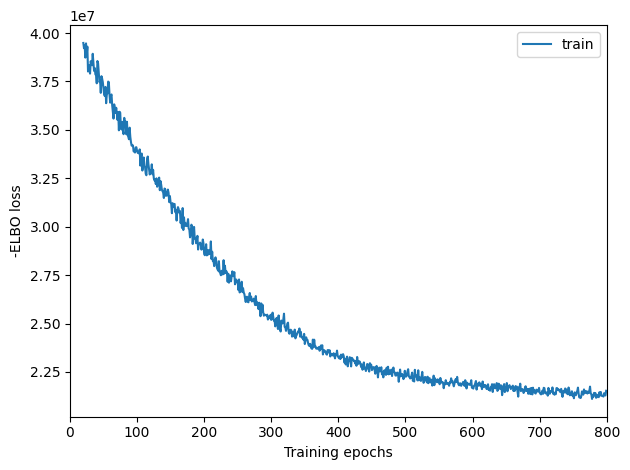

In [12]:
mod.plot_history(20)

In [13]:
# Export the estimated cell abundance (summary of the posterior distribution)
sc_ref = mod.export_posterior(
    sc_ref, sample_kwargs={'num_samples': 1000,}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:02<00:00, 347.60it/s]


In [14]:
# Save model
mod.save('../data/model', overwrite = True)

In [15]:
# Save anndata object with results
sc_ref.write('../data/adata_modelled.h5ad')
sc_ref

AnnData object with n_obs × n_vars = 3261 × 11243
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'tumor_cell', 'cnv_leiden', 'cnv_score', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'chromosome', 'start', 'end', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'SYMBOL', 'nonz_mean'
    uns: 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'tumor_cell_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs', 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'
    layers: 'counts'
    obsp: 

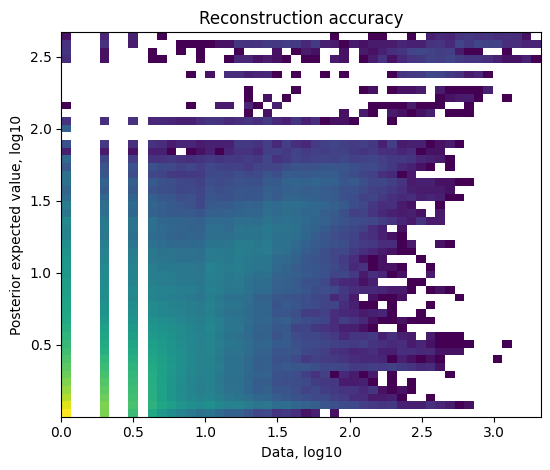

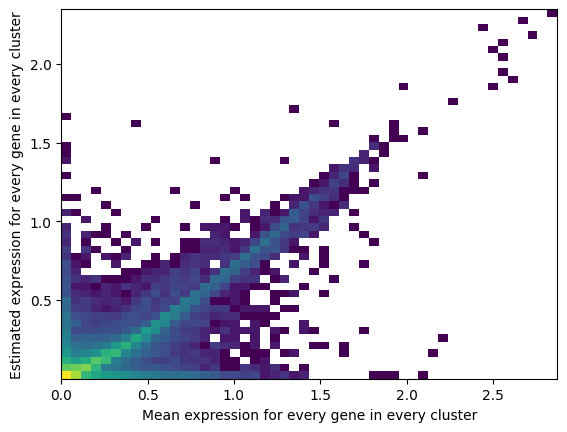

In [16]:
mod.plot_QC()

In [17]:
sc_ref

AnnData object with n_obs × n_vars = 3261 × 11243
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'tumor_cell', 'cnv_leiden', 'cnv_score', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'chromosome', 'start', 'end', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'SYMBOL', 'nonz_mean'
    uns: 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'tumor_cell_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs', 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'
    layers: 'counts'
    obsp: 

In [18]:
# Export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in sc_ref.varm.keys():
    inf_aver = sc_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                       for i in sc_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = sc_ref.var[[f'means_per_cluster_mu_fg_{i}'
                           for i in sc_ref.uns['mod']['factor_names']]].copy() 
inf_aver.columns = sc_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Malignant,Mo/Mp,Microglia,CD4,CD8
gene_ids,,,,,
ENSG00000225880,0.025898,0.012293,0.040366,0.008388,0.005969
ENSG00000230368,0.009052,0.003938,0.023126,0.004455,0.002329
ENSG00000188976,0.168302,0.033147,0.072085,0.052782,0.064015
ENSG00000188290,0.006502,0.026078,0.030692,0.012683,0.002701
ENSG00000187608,0.413070,0.205262,0.504563,0.319425,0.516544


In [19]:
inf_aver.to_csv('../data/inf_aver.csv')